# Locking a Fabry-Perot Cavity

Author: Anna Green

_This notebook was developed as part of a series of tutorial workshops at the University of Florida in 2019. It is currently in the process of being 'polished' to fit the Learn Interferometry course._

In [1]:
from pykat import finesse        # import the whole pykat.finesse package
from pykat.commands import *     # import all packages in pykat.commands
import numpy as np               # for basic math/sci/array functions
import matplotlib.pyplot as plt  # for plotting

# tell the notebook to automatically show plots inline below each cell
%matplotlib inline               
# use pykat's plotting style. change dpi to change plot sizes on your screen
pykat.init_pykat_plotting(dpi=90)


                                              ..-
    PyKat develop         _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat



### a quick introduction to the 'lock' command

Recall: PDH error signal for a FP cavity:

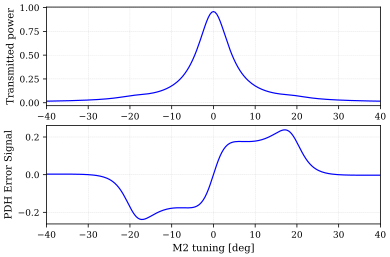

In [2]:
#initialise Finesse with a new empty kat object
basekat = finesse.kat() 
#tell Finesse to talk less
basekat.verbose = False
#parse the Finesse code into PyKat
basekat.parse("""
l laser 1 0 n0

#modulator
s smod 0 n0 nmod1
mod eom 80M 0.3 1 pm nmod1 nmod2
s s0 0 nmod2 n1

#the cavity:
m1 M1 0.15 0 0 n1 n2
s scav 0.2 n2 n3
m1 M2 0.15 0 0 n3 n4

#Gaussian model
attr M1 Rc -0.15
attr M2 Rc 0.15
cav FPcav M1 n2 M2 n3
maxtem 2

#photodiode and xaxis
pd Ptrans n4
pd1 PDH 80M 0 n2
xaxis M2 phi lin -40 40 200
""")

def pltPE(kat,label=None):
    out=kat.run()
    ax1.plot(out.x,out["Ptrans"],label=label)
    ax1.set_ylabel("Transmitted power")
    ax2.plot(out.x,out["PDH"])
    ax2.set_xlabel('M2 tuning [deg]')
    ax2.set_ylabel('PDH Error Signal')
    if label:
        ax1.legend()

fig,(ax1,ax2) =plt.subplots(2,1)
pltPE(basekat)

**static, simple model:**

mirror tunings of zero means the cavity is on resonance. Unlike reality, we don't need an active feedback loop to keep this true.

**more compex model with more going on:**

changing one variable somewhere in the model ends up also affecting the resonant condition of the cavity, so we *do* need an active control to stay at the cavity's operating point and mimic the true situation in the experimental setup.

 * simplest artificial case here: M1 tuning is non-zero for some external reason
 * more complex and realistic cases, e.g. 
     1. mode mismatch or misalignment in arm cavities mean contrast defect at BS no longer target value. 
     2. with no loops in Finesse model, this would just mean the power transmitted to the dark port would go up. 
     3. However, LIGO has a loop set to *hold* the dark port power at a specified value, so this loop would see the increase in power and try to counteract it, e.g. by adjusting the ETM differential tunings. 
     4. The cavity circulatng power would drop as a result, which would show up as a drop in PRG, so now PRM or ITMs gets moved to try and counteract *that*. Meanwhile the dark port power is reduced due to the lower arm power, so that one is happy, but the PRCL loop then acts to try and restore that power, etc etc. 
     5. And of course, the gain of every loop is changing as the power in that part of the system changes too. 
     6. So while in the no-locks case the mismatch just shows as a contrast defect change, in LIGO it has lots of knock-on effects that the loops work to try and compensate.


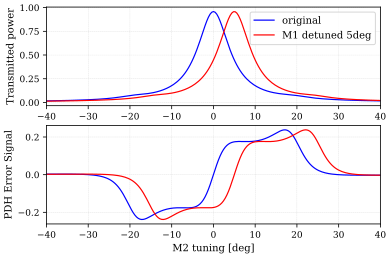

In [3]:
k = basekat.deepcopy()
k.M1.phi = 5
fig,(ax1,ax2) =plt.subplots(2,1)
pltPE(basekat,label='original')
pltPE(k,label='M1 detuned 5deg')

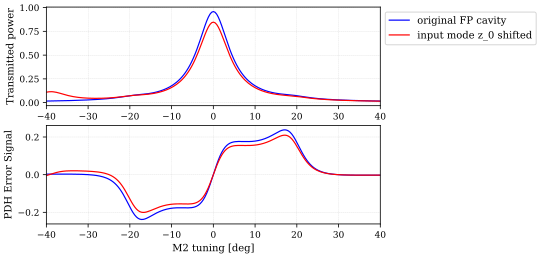

In [4]:
k = basekat.deepcopy()
k.parse("""
gauss input laser n0 150u -0.15""")
fig,(ax1,ax2) =plt.subplots(2,1)
pltPE(basekat,label='original FP cavity')
pltPE(k,label='input mode z_0 shifted')
ax1.legend(loc=2,bbox_to_anchor=(1,1))

#### The `lock` command in Finesse

This is *not* a true feedback loop. It doesn't actively and dynamically respond to the system using any kind of transfer function with electronic filters etc. It just tries to mimic a simple integrator:

For each step of the x-axis command:
1. read the value of the associated variable. This acts as the error signal. It's usually a (demodulated) photodiode, turned into a variable directly using `set` or via some additional mathematics using `func`. 
2. write this value to the new output with your choice of name. 
3. update the value of the output to `new_val = old_val + gain * variable`, and apply this to the specified optic parameter
4. calculate the interferometer matrix and read the resulting value of the variable.
5. if `|variable|>accuracy`, iterate steps 3 & 4 until `|variable|<=accuracy`
6. store all the interferometer outputs in `out`. 
7. move to the next x-axis step and repeat 1-6.

Obviously it will fail if:
 - the loop is not closed,
 - the error signal is not good,
 - the computation is not started at or close to a good operating point,
 - the gain is wrong (sign, amplitude) or,
 - the steps as given by the xaxis command are too large (i.e. moves the interferometer out of the linear range of the error signal).

A fine tuning of the gain is useful to minimise the computation time

#### basic syntax:
E.g. for a simple cavity with a PDH error signal on reflection called `pdh` and mirrors `m1` and `m2`:
```
set err pdh re 
lock z $err -10 10n 
put* m1 phi $z
```
 * `set` defines the variable, `err` used in the iterative loop
 * `lock` defines the gain and accuracy used in each integrator-like iteration
 * `put*` applies the output of the loop as a delta to the current tuning of `m1`.
 
You might also see something like 
```
set err pdh re 
func newerr = $err + 1E-1
lock z $newerr -10 10n
put* m1 phi $z
```
 * `func` applies additional maths to the variable before it is used in the integrator-like iterating loop. It can be quite temperamental, so see the <a href="http://www.gwoptics.org/finesse/reference/">syntax reference</a> for guidance.

--------------------------------------------------------------
Running kat - Started at 2019-09-03 18:01:00.590144
Used Finesse 2.2 at /Users/annagreen/GIT/Finesse/finesse/kat

Finished in 0.038059 seconds


 98% | ETA:  0:00:00 | Calculating                                             

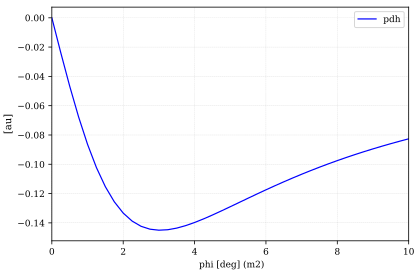

Parsing `set err pdh re` into pykat object not implemented yet, added as extra line.
--------------------------------------------------------------
Running kat - Started at 2019-09-03 18:01:00.764994


 98% | ETA:  0:00:00 | Calculating - Locked ✓ (Locking steps tried 5/10000)    

Used Finesse 2.2 at /Users/annagreen/GIT/Finesse/finesse/kat

Finished in 0.0396688 seconds


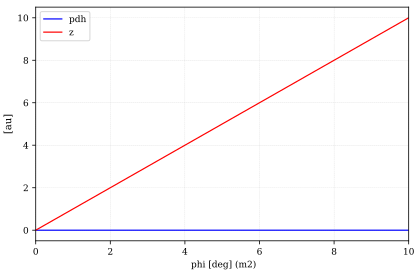

Parsing `set err pdh re` into pykat object not implemented yet, added as extra line.
--------------------------------------------------------------
Running kat - Started at 2019-09-03 18:01:00.973093
Used Finesse 2.2 at /Users/annagreen/GIT/Finesse/finesse/kat

Finished in 0.0449607 seconds


 98% | ETA:  0:00:00 | Calculating - Locked ✓ (Locking steps tried 16/10000)   

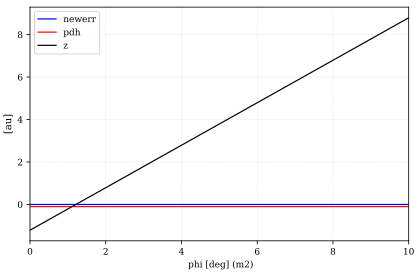

In [5]:
kat = finesse.kat()
kat.parse("""l i1 1 0 n0 
mod eo1 40k 0.3 3 pm n0 n11
s s0 0 n11 n1

m m1 0.9 0.1 0 n1 n2 
s s1 1200 n2 n3 
m m2 .9 0.01 0 n3 n4 

pd1 pdh 40k 0 n1 
xaxis m2 phi lin 0 10 40""")
o=kat.run()
o.plot()

kat1 = kat.deepcopy()
kat1.parse("""

set err pdh re 
lock z $err -10 10n 
put* m1 phi $z""")
o=kat1.run()
o.plot()

kat2 = kat.deepcopy()
kat.parse("""
set err pdh re 
func newerr = $err + 1E-1
lock z $newerr -10 10n
put* m1 phi $z""")
o=kat.run()
o.plot()

#### <font color='Teal'> Task: set up a FP cavity that is locked so that the input mirror follows the end mirror</font>

How to choose the gain? 
 - here, could just use 1:1.
 - optimize based on slope of errsig
 - no offset in the lock itself; you'd need a func to do that

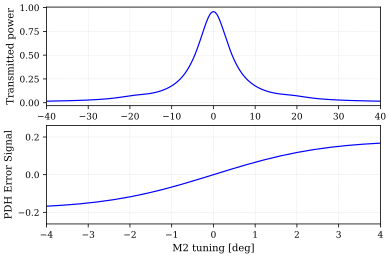

--------------------------------------------------------------
Running kat - Started at 2019-09-03 18:01:01.510718


100% | ETA:  0:00:00 | Calculating - Locked ✓ (Locking steps tried 7/10000)    

Used Finesse 2.2 at /Users/annagreen/GIT/Finesse/finesse/kat

Finished in 0.228646 seconds


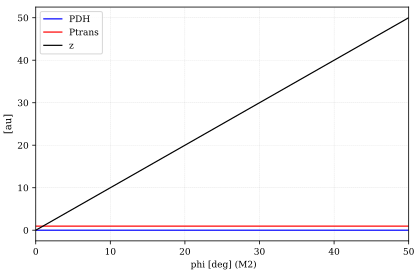

In [6]:
kat = basekat.deepcopy()

fig,(ax1,ax2) = plt.subplots(2,1)
pltPE(kat)
ax2.set_xlim(-4,4)
plt.show()

slopeguess = 1/0.08#dx/dy
kat.parse("""
set err PDH re 
lock z $err {} 10n 
put* M1 phi $z
xaxis M2 phi lin 0 50 400
""".format(slopeguess))
kat.verbose=True
o=kat.run()
o.plot()

#### <font color='Purple'> Take-away: setting and optimising locks</font>
1. the `lock` command isn't a true feedback loop, but an iterative flat integrator computed at each discrete xaxis step.
1. the `lock` and `func` commands are a bit finniky to set up and take a lot of manual tuning to absolutely optimise. They break easily if something is set wrong
2. the `lock` command means that a multi-step iteration of the whole interferometer calculation for every x-axis value. I.e., it's **slow**, especially if not perfectly optimised.